In [1]:
import numpy as np
from scipy.optimize import minimize_scalar
from parse_graphs import load_dimacs_graph, create_optimization_matrix
import matplotlib.pyplot as plt
import time

### Objective Functions

In [2]:
def obj_l2(x, A, alpha = 0.5):
    return x.T @ A @ x + alpha * (x @ x)

def grad_l2(x, A, alpha = 0.5):
    return 2 * A @ x + alpha * 2 * x

# equation 33
def obj_l0(x, A, alpha=0.07, beta=5):
    val = x.T @ (A @ x)
    return float(val) + alpha * np.sum(np.exp(-beta * x) - 1)

def grad_l0(x, A, alpha=0.07, beta=5):
    return 2 * (A @ x) - alpha * beta * np.exp(-beta * x)

### Utility Functions

In [3]:
def LMO(gradient):
    i = np.argmin(gradient)
    s_fw = np.zeros_like(gradient)
    s_fw[i] = 1.0
    return s_fw, i

# Comment for Sasha ->
# Degree-based initialization:
# Initialize x proportional to node degrees. 
# High-degree nodes are more likely part of large cliques, 
# so this biases the algorithm toward promising regions.
def degree_based_initialization(A):
    n = A.shape[0]
    degrees = A.sum(axis=1)
    x_init = degrees / degrees.sum()
    return x_init

# Degree-Randomized Initialization:
# Starts x proportional to node degrees, with small random noise.
# This biases the solution toward high-degree nodes (likely clique members),
# while still allowing exploration. Especially useful for Away-Step FW,
# since it provides an informative but not overly concentrated starting point,
# making away steps more effective at pruning weak vertices.
def degree_random_initialization(A, eps=1e-2, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = A.shape[0]
    degrees = A.sum(axis=1).astype(float)
    x = degrees / degrees.sum()
    x += eps * rng.random(n)
    x /= x.sum()
    return x

def exact_line_search(func, x, direction, max_step=1.0):
    if max_step <= 1e-12:
        return 0.0
    phi = lambda gamma: -func(x + gamma * direction)
    res = minimize_scalar(phi, bounds=(0, max_step), method='bounded')
    if res.success:
        return res.x
    return 0.0

def armijo_line_search(func, x, gradient, direction, A_matrix, initial_step=1.0, c1=0.1, tau=0.5, max_iter=100):
    cur_val = func(x, A_matrix)
    step = initial_step
    grad_dot_dir = np.dot(gradient, direction)
    
    for _ in range(max_iter):
        x_new = x + step * direction
        new_val = func(x_new, A_matrix)
        if new_val >= cur_val + c1 * step * grad_dot_dir:
            return step
        step *= tau
    return 0.0


def away_step_vertex(x, gradient, tol=1e-12):
    active_set = np.where(x > tol)[0]
    if active_set.size == 0:
        raise ValueError("Active set is empty.")
    worst_idx = active_set[np.argmax(gradient[active_set])]
    v = np.zeros_like(x)
    v[worst_idx] = 1.0
    return v, worst_idx

def log_adaptive_step_size(t):
    return (2 + np.log(t + 1)) / (t + 2 + np.log(t + 1))


In [4]:
def extract_clique_from_solution(x, W, threshold=0.01):
    candidates = np.argsort(-x)
    clique = []

    for i in candidates:
        if x[i] < threshold:
            break
        if all(W[i, j] == 1 for j in clique):
            clique.append(i)

    return clique, len(clique)

### Frank-Wolfe Algorithm

In [5]:
def frank_wolfe(obj_func, grad_obj_func, A, num_iters=100, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    #x = np.ones(n) / n
    x = degree_based_initialization(A)

    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(num_iters):
        grad = grad_obj_func(x, A)
        vertex, _ = LMO(-grad)
        direction = vertex - x

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 2), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(iter + 1)
        elif line_search == 'fixed':
            step = 0.25

        # Update
        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x
        
        # added better condition for optimization problems with objectives that can vary widely in magnitude
        if abs(cur_func - history[-2]) / max(1, abs(history[-2])) < tol:
            print(f"Converged at iteration {iter+1}, relative update = {cur_func - history[-2]:.2e}")
            break

        if verbose and iter % 10 == 0:
                print(f"Iter {iter+1:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history

In [5]:
#A = load_dimacs_graph("graphs/C125.9.clq")
A = load_dimacs_graph("graphs/C250.9.clq")
alpha = 0.5
A.shape
A

array([[0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])

Exact Line Search

In [7]:
x_opt_FW_exact_l2, history_FW_exact_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'exact')
clique_FW_exact_l2, size_clique_FW_exact_l2 = extract_clique_from_solution(x_opt_FW_exact_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_exact_l2}.')

Iter   1: f(x) = 0.902859, step = 0.0962
Iter  11: f(x) = 0.935238, step = 0.0749
Iter  21: f(x) = 0.956203, step = 0.0548
Iter  31: f(x) = 0.967783, step = 0.0422
Iter  41: f(x) = 0.973751, step = 0.0285
Iter  51: f(x) = 0.976536, step = 0.0203
Iter  61: f(x) = 0.978112, step = 0.0161
Iter  71: f(x) = 0.979193, step = 0.0138
Iter  81: f(x) = 0.980002, step = 0.0121
Iter  91: f(x) = 0.980627, step = 0.0107
Iter 101: f(x) = 0.981125, step = 0.0096
Iter 111: f(x) = 0.981534, step = 0.0087
Iter 121: f(x) = 0.981874, step = 0.0080
Iter 131: f(x) = 0.982162, step = 0.0074
Iter 141: f(x) = 0.982410, step = 0.0069
Iter 151: f(x) = 0.982625, step = 0.0064
Iter 161: f(x) = 0.982813, step = 0.0060
Iter 171: f(x) = 0.982980, step = 0.0057
Iter 181: f(x) = 0.983128, step = 0.0054
Iter 191: f(x) = 0.983261, step = 0.0051
Iter 201: f(x) = 0.983381, step = 0.0048
Iter 211: f(x) = 0.983489, step = 0.0046
Iter 221: f(x) = 0.983588, step = 0.0044
Iter 231: f(x) = 0.983679, step = 0.0042
Iter 241: f(x) =

Armijo Line Search

In [8]:
x_opt_FW_armijo_l2, history_FW_armijo_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'armijo')
clique_FW_armijo_l2, size_clique_FW_armijo_l2 = extract_clique_from_solution(x_opt_FW_armijo_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l2}.')

Iter   1: f(x) = 0.902449, step = 0.1250
Iter  11: f(x) = 0.939172, step = 0.1250
Iter  21: f(x) = 0.957953, step = 0.1250
Iter  31: f(x) = 0.973797, step = 0.0625
Iter  41: f(x) = 0.978931, step = 0.0625
Iter  51: f(x) = 0.982677, step = 0.0312
Iter  61: f(x) = 0.983773, step = 0.0156
Iter  71: f(x) = 0.984395, step = 0.0156
Iter  81: f(x) = 0.984677, step = 0.0078
Iter  91: f(x) = 0.984835, step = 0.0078
Iter 101: f(x) = 0.984901, step = 0.0039
Iter 111: f(x) = 0.984957, step = 0.0039
Iter 121: f(x) = 0.984986, step = 0.0039
Iter 131: f(x) = 0.985009, step = 0.0039
Iter 141: f(x) = 0.985039, step = 0.0039
Iter 151: f(x) = 0.985065, step = 0.0039
Iter 161: f(x) = 0.985086, step = 0.0039
Iter 171: f(x) = 0.985108, step = 0.0039
Iter 181: f(x) = 0.985134, step = 0.0039
Iter 191: f(x) = 0.985155, step = 0.0039
Iter 201: f(x) = 0.985173, step = 0.0039
Iter 211: f(x) = 0.985195, step = 0.0039
Iter 221: f(x) = 0.985215, step = 0.0039
Iter 231: f(x) = 0.985231, step = 0.0039
Iter 241: f(x) =

Deminishing

In [9]:
x_opt_FW_demin_l2, history_FW_demin_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='demin')
clique_FW_demin_l2, size_clique_FW_demin_l2 = extract_clique_from_solution(x_opt_FW_demin_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_demin_l2}')

Iter   1: f(x) = 0.500000, step = 1.0000
Iter  11: f(x) = 0.941919, step = 0.1667
Iter  21: f(x) = 0.968975, step = 0.0909
Iter  31: f(x) = 0.978831, step = 0.0625
Iter  41: f(x) = 0.981114, step = 0.0476
Iter  51: f(x) = 0.981719, step = 0.0385
Iter  61: f(x) = 0.982484, step = 0.0323
Iter  71: f(x) = 0.982925, step = 0.0278
Iter  81: f(x) = 0.983052, step = 0.0244
Iter  91: f(x) = 0.983237, step = 0.0217
Iter 101: f(x) = 0.983396, step = 0.0196
Iter 111: f(x) = 0.983443, step = 0.0179
Iter 121: f(x) = 0.983510, step = 0.0164
Iter 131: f(x) = 0.983585, step = 0.0152
Iter 141: f(x) = 0.983609, step = 0.0141
Iter 151: f(x) = 0.983639, step = 0.0132
Iter 161: f(x) = 0.983680, step = 0.0123
Iter 171: f(x) = 0.983694, step = 0.0116
Iter 181: f(x) = 0.983709, step = 0.0110
Iter 191: f(x) = 0.983734, step = 0.0104
Converged at iteration 195, relative update = 9.88e-07
Extracted Max Clique is of size: 31


Open-Loop Step Size

In [10]:
x_opt_FW_log_l2, history_FW_log_l2 = frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='log')
clique_FW_log_l2, size_clique_FW_log_l2 = extract_clique_from_solution(x_opt_FW_log_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_log_l2}.')


Iter   1: f(x) = 0.705221, step = 0.7292
Iter  11: f(x) = 0.909239, step = 0.2896
Iter  21: f(x) = 0.942109, step = 0.1951
Iter  31: f(x) = 0.956650, step = 0.1499
Iter  41: f(x) = 0.964997, step = 0.1228
Iter  51: f(x) = 0.970259, step = 0.1045
Iter  61: f(x) = 0.973733, step = 0.0913
Iter  71: f(x) = 0.976130, step = 0.0812
Iter  81: f(x) = 0.977858, step = 0.0733
Iter  91: f(x) = 0.979146, step = 0.0669
Iter 101: f(x) = 0.980133, step = 0.0616
Iter 111: f(x) = 0.980907, step = 0.0571
Iter 121: f(x) = 0.981525, step = 0.0532
Iter 131: f(x) = 0.982028, step = 0.0499
Iter 141: f(x) = 0.982443, step = 0.0470
Iter 151: f(x) = 0.982789, step = 0.0444
Iter 161: f(x) = 0.983081, step = 0.0422
Iter 171: f(x) = 0.983330, step = 0.0401
Iter 181: f(x) = 0.983544, step = 0.0383
Iter 191: f(x) = 0.983729, step = 0.0366
Iter 201: f(x) = 0.983891, step = 0.0351
Iter 211: f(x) = 0.984033, step = 0.0337
Iter 221: f(x) = 0.984159, step = 0.0324
Iter 231: f(x) = 0.984270, step = 0.0312
Iter 241: f(x) =

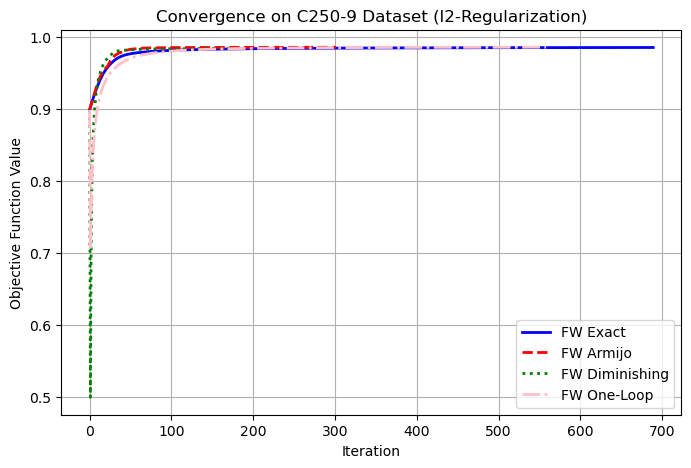

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history_FW_exact_l2, label='FW Exact', color='blue', linewidth=2, linestyle='-')
plt.plot(history_FW_armijo_l2, label='FW Armijo', color='red', linewidth=2, linestyle='--')
plt.plot(history_FW_demin_l2, label='FW Diminishing', color='green', linewidth=2, linestyle=':')
plt.plot(history_FW_log_l2, label='FW One-Loop', color='pink', linewidth=2, linestyle='-.')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l2-Regularization)")
plt.legend()
plt.grid(True)
plt.show()




### FW on l0-regularized objective function

Exact Line Search

In [12]:
x_opt_FW_exact_l0, history_FW_exact_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'exact')
clique_FW_exact_l0, size_clique_FW_exact_l0 = extract_clique_from_solution(x_opt_FW_exact_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_exact_l0}.')


Iter   1: f(x) = 0.557140, step = 0.1308
Iter  11: f(x) = 0.604733, step = 0.0941
Iter  21: f(x) = 0.624851, step = 0.0553
Iter  31: f(x) = 0.633645, step = 0.0491
Iter  41: f(x) = 0.637888, step = 0.0379
Iter  51: f(x) = 0.639909, step = 0.0239
Iter  61: f(x) = 0.640989, step = 0.0185
Iter  71: f(x) = 0.641678, step = 0.0158
Iter  81: f(x) = 0.642177, step = 0.0134
Iter  91: f(x) = 0.642555, step = 0.0117
Iter 101: f(x) = 0.642847, step = 0.0107
Iter 111: f(x) = 0.643081, step = 0.0094
Iter 121: f(x) = 0.643274, step = 0.0086
Iter 131: f(x) = 0.643435, step = 0.0079
Iter 141: f(x) = 0.643572, step = 0.0073
Iter 151: f(x) = 0.643690, step = 0.0066
Iter 161: f(x) = 0.643793, step = 0.0064
Iter 171: f(x) = 0.643883, step = 0.0060
Iter 181: f(x) = 0.643963, step = 0.0056
Iter 191: f(x) = 0.644034, step = 0.0053
Iter 201: f(x) = 0.644097, step = 0.0050
Iter 211: f(x) = 0.644155, step = 0.0048
Iter 221: f(x) = 0.644207, step = 0.0046
Iter 231: f(x) = 0.644254, step = 0.0044
Iter 241: f(x) =

Armijo line search

In [13]:
x_opt_FW_armijo_l0, history_FW_armijo_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'armijo')
clique_FW_armijo_l0, size_clique_FW_armijo_l0 = extract_clique_from_solution(x_opt_FW_armijo_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_armijo_l0}.')


Iter   1: f(x) = 0.557122, step = 0.1250
Iter  11: f(x) = 0.605692, step = 0.1250
Iter  21: f(x) = 0.625180, step = 0.1250
Iter  31: f(x) = 0.636623, step = 0.0625
Iter  41: f(x) = 0.640802, step = 0.0625
Iter  51: f(x) = 0.642980, step = 0.0312
Iter  61: f(x) = 0.643699, step = 0.0312
Iter  71: f(x) = 0.644225, step = 0.0156
Iter  81: f(x) = 0.644479, step = 0.0156
Iter  91: f(x) = 0.644611, step = 0.0078
Iter 101: f(x) = 0.644688, step = 0.0078
Iter 111: f(x) = 0.644722, step = 0.0078
Iter 121: f(x) = 0.644758, step = 0.0078
Iter 131: f(x) = 0.644799, step = 0.0078
Iter 141: f(x) = 0.644834, step = 0.0078
Iter 151: f(x) = 0.644858, step = 0.0078
Iter 161: f(x) = 0.644888, step = 0.0078
Iter 171: f(x) = 0.644920, step = 0.0078
Iter 181: f(x) = 0.644944, step = 0.0039
Iter 191: f(x) = 0.644977, step = 0.0039
Converged at iteration 200, relative update = 8.24e-07
Extracted Max Clique is of size: 35.


Deminishing Step Size

In [14]:
x_opt_FW_demin_l0, history_FW_demin_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'demin')
clique_FW_demin_l0, size_clique_FW_demin_l0 = extract_clique_from_solution(x_opt_FW_demin_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_demin_l0}.')

Iter   1: f(x) = -0.069528, step = 1.0000
Iter  11: f(x) = 0.616730, step = 0.1667
Iter  21: f(x) = 0.636475, step = 0.0909
Iter  31: f(x) = 0.641945, step = 0.0625
Iter  41: f(x) = 0.643065, step = 0.0476
Iter  51: f(x) = 0.643395, step = 0.0385
Iter  61: f(x) = 0.643802, step = 0.0323
Iter  71: f(x) = 0.644023, step = 0.0278
Iter  81: f(x) = 0.644089, step = 0.0244
Iter  91: f(x) = 0.644186, step = 0.0217
Iter 101: f(x) = 0.644266, step = 0.0196
Iter 111: f(x) = 0.644290, step = 0.0179
Iter 121: f(x) = 0.644325, step = 0.0164
Iter 131: f(x) = 0.644363, step = 0.0152
Converged at iteration 138, relative update = 9.98e-07
Extracted Max Clique is of size: 31.


Open-Loop Step Size

In [15]:
x_opt_FW_log_l0, history_FW_log_l0 = frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'log')
clique_FW_log_l0, size_clique_FW_log_l0 = extract_clique_from_solution(x_opt_FW_log_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_FW_log_l0}.')

Iter   1: f(x) = 0.276055, step = 0.7292
Iter  11: f(x) = 0.582165, step = 0.2896
Iter  21: f(x) = 0.615154, step = 0.1951
Iter  31: f(x) = 0.627170, step = 0.1499
Iter  41: f(x) = 0.633202, step = 0.1228
Iter  51: f(x) = 0.636658, step = 0.1045
Iter  61: f(x) = 0.638794, step = 0.0913
Iter  71: f(x) = 0.640201, step = 0.0812
Iter  81: f(x) = 0.641182, step = 0.0733
Iter  91: f(x) = 0.641895, step = 0.0669
Iter 101: f(x) = 0.642430, step = 0.0616
Iter 111: f(x) = 0.642843, step = 0.0571
Iter 121: f(x) = 0.643169, step = 0.0532
Iter 131: f(x) = 0.643432, step = 0.0499
Iter 141: f(x) = 0.643646, step = 0.0470
Iter 151: f(x) = 0.643824, step = 0.0444
Iter 161: f(x) = 0.643973, step = 0.0422
Iter 171: f(x) = 0.644099, step = 0.0401
Iter 181: f(x) = 0.644208, step = 0.0383
Iter 191: f(x) = 0.644301, step = 0.0366
Iter 201: f(x) = 0.644382, step = 0.0351
Iter 211: f(x) = 0.644453, step = 0.0337
Iter 221: f(x) = 0.644516, step = 0.0324
Iter 231: f(x) = 0.644571, step = 0.0312
Iter 241: f(x) =

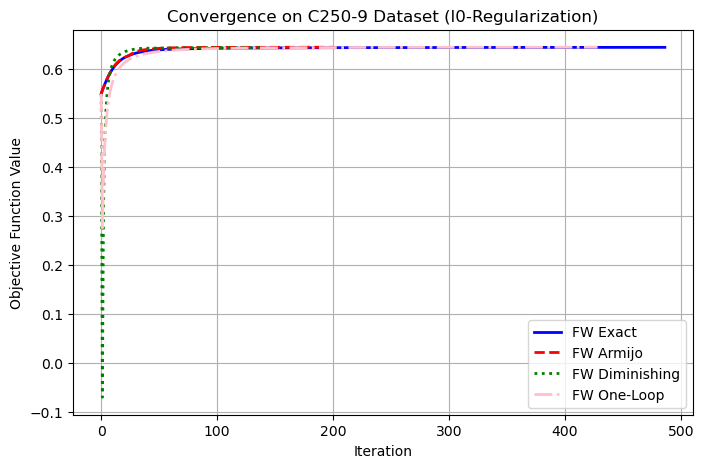

In [16]:
plt.figure(figsize=(8,5))
plt.plot(history_FW_exact_l0, label='FW Exact', color='blue', linewidth=2, linestyle='-')
plt.plot(history_FW_armijo_l0, label='FW Armijo', color='red', linewidth=2, linestyle='--')
plt.plot(history_FW_demin_l0, label='FW Diminishing', color='green', linewidth=2, linestyle=':')
plt.plot(history_FW_log_l0, label='FW One-Loop', color='pink', linewidth=2, linestyle='-.')
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence on C250-9 Dataset (l0-Regularization)")
plt.legend()
plt.grid(True)
plt.show()



### Away Step FW Algorithm

In [6]:
def away_step_frank_wolfe(obj_func, grad_obj_func, A, num_iters=100, line_search=None, tol=1e-6, verbose=True):
    n = A.shape[0]
    #x = np.ones(n) / n
    x = degree_based_initialization(A)
    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for iter in range(1, num_iters + 1):
        grad = grad_obj_func(x, A)
        vertex_fw, _ = LMO(-grad)
        direction_fw = vertex_fw - x
        gap_fw = np.dot(-grad, direction_fw)

        vertex_as, v_idx = away_step_vertex(x, -grad)
        direction_as = x - vertex_as
        gap_as = np.dot(-grad, direction_as)

        if gap_fw >= gap_as or np.count_nonzero(x) == 1:
            direction = direction_fw
            max_step = 1.0
        else:
            direction = direction_as
            alpha = x[v_idx]
            max_step = alpha / (1 - alpha) if alpha < 1.0 else 1.0

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, direction, max_step=max_step)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, direction, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (iter + 2), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(iter + 1)

        x += step * direction
        cur_func = obj_func(x, A)
        history.append(cur_func)

        if cur_func > best_func:
            best_func = cur_func
            opt_x = x.copy()

        if abs(cur_func - history[-2]) < tol:
            break

        if verbose and iter % 10 == 0:
            print(f"Iter {iter:3d}: f(x) = {cur_func:.6f}, step = {step:.4f}")

    return opt_x, history


L2 Objective

In [7]:
# Away-Step Frank-Wolfe with l2 regularization and exact line search
x_opt_ASFW_exact_l2, history_ASFW_exact_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search= 'exact')
clique_ASFW_exact_l2, size_clique_ASFW_exact_l2 = extract_clique_from_solution(x_opt_ASFW_exact_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_exact_l2}.')


Iter  10: f(x) = 0.932384, step = 0.0764
Iter  20: f(x) = 0.954670, step = 0.0575
Iter  30: f(x) = 0.966874, step = 0.0432
Iter  40: f(x) = 0.973343, step = 0.0297
Iter  50: f(x) = 0.976332, step = 0.0209
Iter  60: f(x) = 0.977984, step = 0.0165
Iter  70: f(x) = 0.979099, step = 0.0140
Iter  80: f(x) = 0.979931, step = 0.0122
Iter  90: f(x) = 0.980571, step = 0.0108
Iter 100: f(x) = 0.981080, step = 0.0097
Iter 110: f(x) = 0.981496, step = 0.0088
Iter 120: f(x) = 0.981843, step = 0.0081
Iter 130: f(x) = 0.982136, step = 0.0075
Iter 140: f(x) = 0.982387, step = 0.0069
Iter 150: f(x) = 0.982605, step = 0.0065
Iter 160: f(x) = 0.982796, step = 0.0061
Iter 170: f(x) = 0.982964, step = 0.0057
Iter 180: f(x) = 0.983114, step = 0.0054
Iter 190: f(x) = 0.983248, step = 0.0051
Iter 200: f(x) = 0.983369, step = 0.0049
Iter 210: f(x) = 0.983479, step = 0.0046
Iter 220: f(x) = 0.983579, step = 0.0044
Iter 230: f(x) = 0.983670, step = 0.0042
Iter 240: f(x) = 0.983753, step = 0.0041
Iter 250: f(x) =

In [19]:
# Away-Step Frank-Wolfe with l2 regularization and Armijo line search
x_opt_ASFW_armijo_l2, history_ASFW_armijo_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='armijo')
clique_ASFW_armijo_l2, size_clique_ASFW_armijo_l2 = extract_clique_from_solution(x_opt_ASFW_armijo_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l2}.')

Iter  10: f(x) = 0.936014, step = 0.1250
Iter  20: f(x) = 0.956893, step = 0.1250
Iter  30: f(x) = 0.972787, step = 0.0625
Iter  40: f(x) = 0.978705, step = 0.0625
Iter  50: f(x) = 0.982516, step = 0.0312
Iter  60: f(x) = 0.983662, step = 0.0156
Iter  70: f(x) = 0.984362, step = 0.0156
Iter  80: f(x) = 0.984650, step = 0.0078
Iter  90: f(x) = 0.984825, step = 0.0078
Iter 100: f(x) = 0.984894, step = 0.0039
Iter 110: f(x) = 0.984952, step = 0.0039
Iter 120: f(x) = 0.984984, step = 0.0039
Iter 130: f(x) = 0.985007, step = 0.0039
Iter 140: f(x) = 0.985036, step = 0.0039
Iter 150: f(x) = 0.985062, step = 0.0039
Iter 160: f(x) = 0.985085, step = 0.0039
Iter 170: f(x) = 0.985106, step = 0.0039
Iter 180: f(x) = 0.985132, step = 0.0039
Iter 190: f(x) = 0.985153, step = 0.0039
Iter 200: f(x) = 0.985171, step = 0.0039
Iter 210: f(x) = 0.985193, step = 0.0039
Iter 220: f(x) = 0.985213, step = 0.0039
Iter 230: f(x) = 0.985230, step = 0.0039
Iter 240: f(x) = 0.985246, step = 0.0039
Iter 250: f(x) =

In [8]:
# Away-Step Frank-Wolfe with l2 regularization and diminishing step size
x_opt_ASFW_demin_l2, history_ASFW_demin_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='demin')     
clique_ASFW_demin_l2, size_clique_ASFW_demin_l2 = extract_clique_from_solution(x_opt_ASFW_demin_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_demin_l2}.')

Iter  10: f(x) = 0.940004, step = 0.1667
Iter  20: f(x) = 0.968358, step = 0.0909
Iter  30: f(x) = 0.978513, step = 0.0625
Iter  40: f(x) = 0.982684, step = 0.0476
Iter  50: f(x) = 0.983401, step = 0.0385
Iter  60: f(x) = 0.983918, step = 0.0323
Iter  70: f(x) = 0.984569, step = 0.0278
Iter  80: f(x) = 0.984849, step = 0.0244
Iter  90: f(x) = 0.984953, step = 0.0217
Iter 100: f(x) = 0.985093, step = 0.0196
Iter 110: f(x) = 0.985253, step = 0.0179
Iter 120: f(x) = 0.985304, step = 0.0164
Iter 130: f(x) = 0.985344, step = 0.0152
Iter 140: f(x) = 0.985416, step = 0.0141
Iter 150: f(x) = 0.985458, step = 0.0132
Iter 160: f(x) = 0.985475, step = 0.0123
Iter 170: f(x) = 0.985501, step = 0.0116
Iter 180: f(x) = 0.985536, step = 0.0110
Extracted Max Clique is of size: 35.


In [9]:
# Away-Step Frank-Wolfe with l2 regularization and one-loop step size
x_opt_ASFW_log_l2, history_ASFW_log_l2 = away_step_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='log') 
clique_ASFW_log_l2, size_clique_ASFW_log_l2 = extract_clique_from_solution(x_opt_ASFW_log_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_log_l2}.')

Iter  10: f(x) = 0.908787, step = 0.2896
Iter  20: f(x) = 0.942073, step = 0.1951
Iter  30: f(x) = 0.956644, step = 0.1499
Iter  40: f(x) = 0.964996, step = 0.1228
Iter  50: f(x) = 0.970258, step = 0.1045
Iter  60: f(x) = 0.973733, step = 0.0913
Iter  70: f(x) = 0.976130, step = 0.0812
Iter  80: f(x) = 0.977858, step = 0.0733
Iter  90: f(x) = 0.979146, step = 0.0669
Iter 100: f(x) = 0.980133, step = 0.0616
Iter 110: f(x) = 0.980907, step = 0.0571
Iter 120: f(x) = 0.981525, step = 0.0532
Iter 130: f(x) = 0.982028, step = 0.0499
Iter 140: f(x) = 0.982443, step = 0.0470
Iter 150: f(x) = 0.982789, step = 0.0444
Iter 160: f(x) = 0.983081, step = 0.0422
Iter 170: f(x) = 0.983330, step = 0.0401
Iter 180: f(x) = 0.983544, step = 0.0383
Iter 190: f(x) = 0.983729, step = 0.0366
Iter 200: f(x) = 0.983891, step = 0.0351
Iter 210: f(x) = 0.984033, step = 0.0337
Iter 220: f(x) = 0.984159, step = 0.0324
Iter 230: f(x) = 0.984261, step = 0.0312
Iter 240: f(x) = 0.984296, step = 0.0301
Iter 250: f(x) =

L0-Regularized Objective

In [10]:
# Away-Step Frank-Wolfe with l0 objective and exact step size
x_opt_ASFW_exact_l0, history_ASFW_exact_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search= 'exact')
clique_ASFW_exact_l0, size_clique_ASFW_exact_l0 = extract_clique_from_solution(x_opt_ASFW_exact_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_exact_l0}.')

Iter  10: f(x) = 0.601404, step = 0.0974
Iter  20: f(x) = 0.623801, step = 0.0677
Iter  30: f(x) = 0.633007, step = 0.0446
Iter  40: f(x) = 0.637552, step = 0.0328
Iter  50: f(x) = 0.639765, step = 0.0246
Iter  60: f(x) = 0.640905, step = 0.0189
Iter  70: f(x) = 0.641618, step = 0.0150
Iter  80: f(x) = 0.642133, step = 0.0141
Iter  90: f(x) = 0.642522, step = 0.0118
Iter 100: f(x) = 0.642819, step = 0.0103
Iter 110: f(x) = 0.643060, step = 0.0095
Iter 120: f(x) = 0.643256, step = 0.0087
Iter 130: f(x) = 0.643420, step = 0.0079
Iter 140: f(x) = 0.643560, step = 0.0073
Iter 150: f(x) = 0.643679, step = 0.0069
Iter 160: f(x) = 0.643783, step = 0.0064
Iter 170: f(x) = 0.643875, step = 0.0060
Iter 180: f(x) = 0.643955, step = 0.0057
Iter 190: f(x) = 0.644027, step = 0.0054
Iter 200: f(x) = 0.644091, step = 0.0051
Iter 210: f(x) = 0.644149, step = 0.0048
Iter 220: f(x) = 0.644202, step = 0.0046
Iter 230: f(x) = 0.644250, step = 0.0044
Iter 240: f(x) = 0.644294, step = 0.0042
Iter 250: f(x) =

In [11]:
#  Away-Step Frank-Wolfe with l0 objective and Armijo step size
x_opt_ASFW_armijo_l0, history_ASFW_armijo_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='armijo')
clique_ASFW_armijo_l0, size_clique_ASFW_armijo_l0 = extract_clique_from_solution(x_opt_ASFW_armijo_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_armijo_l0}.')

Iter  10: f(x) = 0.602227, step = 0.1250
Iter  20: f(x) = 0.623954, step = 0.1250
Iter  30: f(x) = 0.635886, step = 0.0625
Iter  40: f(x) = 0.640615, step = 0.0625
Iter  50: f(x) = 0.642821, step = 0.0312
Iter  60: f(x) = 0.643655, step = 0.0312
Iter  70: f(x) = 0.644184, step = 0.0156
Iter  80: f(x) = 0.644465, step = 0.0156
Iter  90: f(x) = 0.644600, step = 0.0078
Iter 100: f(x) = 0.644682, step = 0.0078
Iter 110: f(x) = 0.644719, step = 0.0078
Iter 120: f(x) = 0.644754, step = 0.0078
Iter 130: f(x) = 0.644794, step = 0.0078
Iter 140: f(x) = 0.644831, step = 0.0078
Iter 150: f(x) = 0.644856, step = 0.0078
Iter 160: f(x) = 0.644885, step = 0.0078
Iter 170: f(x) = 0.644916, step = 0.0078
Iter 180: f(x) = 0.644940, step = 0.0039
Iter 190: f(x) = 0.644975, step = 0.0039
Extracted Max Clique is of size: 35.


In [12]:
# Away-Step Frank-Wolfe with l0 objective and deminishing step size
x_opt_ASFW_demin_l0, history_ASFW_demin_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='demin')
clique_ASFW_demin_l0, size_clique_ASFW_demin_l0 = extract_clique_from_solution(x_opt_ASFW_demin_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_demin_l0}.')

Iter  10: f(x) = 0.699061, step = 0.1667
Iter  20: f(x) = 0.655129, step = 0.0909
Iter  30: f(x) = 0.645505, step = 0.0625
Iter  40: f(x) = 0.645725, step = 0.0476
Iter  50: f(x) = 0.646212, step = 0.0385
Iter  60: f(x) = 0.645579, step = 0.0323
Extracted Max Clique is of size: 1.


In [13]:
# Away-Step Frank-Wolfe with l0 objective and one-loop step size
x_opt_ASFW_log_l0, history_ASFW_log_l0 = away_step_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='log')
clique_ASFW_log_l0, size_clique_ASFW_log_l0 = extract_clique_from_solution(x_opt_ASFW_log_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_ASFW_log_l0}.')

Iter  10: f(x) = 0.581711, step = 0.2896
Iter  20: f(x) = 0.615118, step = 0.1951
Iter  30: f(x) = 0.627164, step = 0.1499
Iter  40: f(x) = 0.633201, step = 0.1228
Iter  50: f(x) = 0.636658, step = 0.1045
Iter  60: f(x) = 0.638794, step = 0.0913
Iter  70: f(x) = 0.640201, step = 0.0812
Iter  80: f(x) = 0.641182, step = 0.0733
Iter  90: f(x) = 0.641895, step = 0.0669
Iter 100: f(x) = 0.642430, step = 0.0616
Iter 110: f(x) = 0.642843, step = 0.0571
Iter 120: f(x) = 0.643169, step = 0.0532
Iter 130: f(x) = 0.643432, step = 0.0499
Iter 140: f(x) = 0.643646, step = 0.0470
Iter 150: f(x) = 0.643824, step = 0.0444
Iter 160: f(x) = 0.643973, step = 0.0422
Iter 170: f(x) = 0.644099, step = 0.0401
Iter 180: f(x) = 0.644208, step = 0.0383
Iter 190: f(x) = 0.644301, step = 0.0366
Iter 200: f(x) = 0.644382, step = 0.0351
Iter 210: f(x) = 0.644453, step = 0.0337
Iter 220: f(x) = 0.644516, step = 0.0324
Iter 230: f(x) = 0.644571, step = 0.0312
Iter 240: f(x) = 0.644621, step = 0.0301
Iter 250: f(x) =

### Pairwise Frank Wolfe

In [ ]:
def pairwise_frank_wolfe(obj_func, grad_obj_func, A, num_iters=100, line_search=None, tol=1e-9, verbose=True, x_init=None):
    n = A.shape[0]
    x = np.ones(n) / n if x_init is None else x_init.copy()
    history = [obj_func(x, A)]
    opt_x = x.copy()
    best_func = history[0]

    for it in range(num_iters):
        grad = grad_obj_func(x, A)
        vertex_fw, i_fw = LMO(-grad)
        vertex_as, i_as = away_step_vertex(x, -grad)

        if i_fw == i_as:
            if verbose:
                print(f"Stationary point reached at iter {it}")
            break

        d = vertex_fw - vertex_as
        gamma_max = x[i_as]

        # Step size strategy
        if line_search =='exact':
            step = exact_line_search(lambda z: obj_func(z, A), x, d, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, d, A, initial_step = 1.0)
        elif line_search == 'demin':
            step = min(2 / (it + 2), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(it + 1)

        step = max(0.0, min(step, gamma_max))

        x[i_fw] += step
        x[i_as] -= step
        x = np.clip(x, 0.0, None)
        s = x.sum()
        if s <= 0:
            x = np.ones(n) / n
        else:
            x /= s

        cur = obj_func(x, A)
        history.append(cur)

        if cur > best_func:
            best_func = cur
            opt_x = x.copy()

        if abs(cur - history[-2]) / max(1, abs(history[-2])) < tol:
            if verbose:
                print(f"Converged at iter {it}, rel change = {cur - history[-2]:.2e}")
            break

        if verbose and it % 10 == 0:
            top = np.argsort(-x)[:8]
            print(f"Iter {it:4d}: f(x)={cur:.6f}, step={step:.4f}, i_fw={i_fw}, i_as={i_as}, top={(top, x[top])}")

    return opt_x, history


In [27]:
# Pairwise Frank-Wolfe with l2 regularization and exact line search
x_opt_PFW_exact_l2, history_PFW_exact_l2 = pairwise_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='exact')
clique_PFW_exact_l2, size_clique_PFW_exact_l2 = extract_clique_from_solution(x_opt_PFW_exact_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_exact_l2}.')

Iter   10: f(x)=0.904624, step=0.0040, i_fw=5, i_as=51, top=(array([  5, 124,  62, 229, 127, 156, 157, 158]), array([0.02 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.912032, step=0.0040, i_fw=5, i_as=106, top=(array([  5, 124,  62, 229, 152, 153, 154, 155]), array([0.06 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.918448, step=0.0040, i_fw=5, i_as=90, top=(array([  5, 124,  62, 229, 150, 151, 152, 153]), array([0.1  , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.923776, step=0.0040, i_fw=229, i_as=169, top=(array([  5,  86, 229, 124,  62, 158, 121, 149]), array([0.104, 0.024, 0.016, 0.016, 0.016, 0.008, 0.004, 0.004]))
Iter   50: f(x)=0.929440, step=0.0040, i_fw=86, i_as=43, top=(array([  5,  86,  62, 229, 124, 158, 167, 176]), array([0.104, 0.044, 0.032, 0.02 , 0.016, 0.008, 0.004, 0.004]))
Iter   60: f(x)=0.935168, step=0.0040, i_fw=62, i_as=87, top=(array([  5,  86,  62, 229, 124, 158, 145, 146]), array([0.

In [28]:
# Pairwise Frank-Wolfe with l2 regularization and armijo line search
x_opt_PFW_armijo_l2, history_PFW_armijo_l2 = pairwise_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='armijo')    
clique_PFW_armijo_l2, size_clique_PFW_armijo_l2 = extract_clique_from_solution(x_opt_PFW_armijo_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_armijo_l2}.')

Iter   10: f(x)=0.904624, step=0.0040, i_fw=5, i_as=51, top=(array([  5, 124,  62, 229, 127, 156, 157, 158]), array([0.02 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.912032, step=0.0040, i_fw=5, i_as=106, top=(array([  5, 124,  62, 229, 152, 153, 154, 155]), array([0.06 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.918448, step=0.0040, i_fw=5, i_as=90, top=(array([  5, 124,  62, 229, 150, 151, 152, 153]), array([0.1  , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.923776, step=0.0040, i_fw=229, i_as=169, top=(array([  5,  86, 229, 124,  62, 158, 121, 149]), array([0.104, 0.024, 0.016, 0.016, 0.016, 0.008, 0.004, 0.004]))
Iter   50: f(x)=0.929440, step=0.0040, i_fw=86, i_as=43, top=(array([  5,  86,  62, 229, 124, 158, 167, 176]), array([0.104, 0.044, 0.032, 0.02 , 0.016, 0.008, 0.004, 0.004]))
Iter   60: f(x)=0.935168, step=0.0040, i_fw=62, i_as=87, top=(array([  5,  86,  62, 229, 124, 158, 145, 146]), array([0.

In [29]:
# Pairwise Frank-Wolfe with l2 regularization and deminishing step size
x_opt_PFW_demin_l2, history_PFW_demin_l2 = pairwise_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='demin')    
clique_PFW_demin_l2, size_clique_PFW_demin_l2 = extract_clique_from_solution(x_opt_PFW_demin_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_demin_l2}.')

Iter   10: f(x)=0.904624, step=0.0040, i_fw=5, i_as=51, top=(array([  5, 124,  62, 229, 127, 156, 157, 158]), array([0.02 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.912032, step=0.0040, i_fw=5, i_as=106, top=(array([  5, 124,  62, 229, 152, 153, 154, 155]), array([0.06 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.918448, step=0.0040, i_fw=5, i_as=90, top=(array([  5, 124,  62, 229, 150, 151, 152, 153]), array([0.1  , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.923776, step=0.0040, i_fw=229, i_as=169, top=(array([  5,  86, 229, 124,  62, 158, 121, 149]), array([0.104, 0.024, 0.016, 0.016, 0.016, 0.008, 0.004, 0.004]))
Iter   50: f(x)=0.929440, step=0.0040, i_fw=86, i_as=43, top=(array([  5,  86,  62, 229, 124, 158, 167, 176]), array([0.104, 0.044, 0.032, 0.02 , 0.016, 0.008, 0.004, 0.004]))
Iter   60: f(x)=0.935168, step=0.0040, i_fw=62, i_as=87, top=(array([  5,  86,  62, 229, 124, 158, 145, 146]), array([0.

In [30]:
# Pairwise Frank-Wolfe with l2 regularization and one-loop step size
x_opt_PFW_log_l2, history_PFW_log_l2 = pairwise_frank_wolfe(obj_l2, grad_l2, A, num_iters=1000, line_search='log')
clique_PFW_log_l2, size_clique_PFW_log_l2 = extract_clique_from_solution(x_opt_PFW_log_l2, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_log_l2}.')

Iter   10: f(x)=0.904624, step=0.0040, i_fw=5, i_as=51, top=(array([  5, 124,  62, 229, 127, 156, 157, 158]), array([0.02 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.912032, step=0.0040, i_fw=5, i_as=106, top=(array([  5, 124,  62, 229, 152, 153, 154, 155]), array([0.06 , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.918448, step=0.0040, i_fw=5, i_as=90, top=(array([  5, 124,  62, 229, 150, 151, 152, 153]), array([0.1  , 0.016, 0.012, 0.008, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.923776, step=0.0040, i_fw=229, i_as=169, top=(array([  5,  86, 229, 124,  62, 158, 121, 149]), array([0.104, 0.024, 0.016, 0.016, 0.016, 0.008, 0.004, 0.004]))
Iter   50: f(x)=0.929440, step=0.0040, i_fw=86, i_as=43, top=(array([  5,  86,  62, 229, 124, 158, 167, 176]), array([0.104, 0.044, 0.032, 0.02 , 0.016, 0.008, 0.004, 0.004]))
Iter   60: f(x)=0.935168, step=0.0040, i_fw=62, i_as=87, top=(array([  5,  86,  62, 229, 124, 158, 145, 146]), array([0.

## l0-regularized objective

In [31]:
# Pairwise Frank-Wolfe with l0 regularization and exact line search
x_opt_PFW_exact_l0, history_PFW_exact_l0 = pairwise_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='exact')
clique_PFW_exact_l0, size_clique_PFW_exact_l0 = extract_clique_from_solution(x_opt_PFW_exact_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_exact_l0}.')

Iter   10: f(x)=0.556390, step=0.0040, i_fw=124, i_as=219, top=(array([124,   5, 155, 156, 157, 158, 159, 160]), array([0.036, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.564869, step=0.0040, i_fw=124, i_as=68, top=(array([124,   5, 154, 155, 156, 157, 158, 159]), array([0.076, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.572068, step=0.0040, i_fw=124, i_as=136, top=(array([124,   5, 153, 154, 156, 157, 158, 159]), array([0.116, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.578421, step=0.0040, i_fw=5, i_as=44, top=(array([124,   5, 148, 149, 150, 152, 153, 154]), array([0.124, 0.044, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   50: f(x)=0.585651, step=0.0040, i_fw=5, i_as=131, top=(array([124,   5, 147, 148, 149, 150, 152, 153]), array([0.124, 0.084, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   60: f(x)=0.590702, step=0.0040, i_fw=83, i_as=191, top=(array([124,   5,  83, 203, 147, 148, 149, 150]), arra

In [32]:
# Pairwise Frank-Wolfe with l0 regularization and armijo line search
x_opt_PFW_armijo_l0, history_PFW_armijo_l0 = pairwise_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='armijo')
clique_PFW_armijo_l0, size_clique_PFW_armijo_l0 = extract_clique_from_solution(x_opt_PFW_armijo_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_armijo_l0}.')

Iter   10: f(x)=0.556390, step=0.0040, i_fw=124, i_as=219, top=(array([124,   5, 155, 156, 157, 158, 159, 160]), array([0.036, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.564869, step=0.0040, i_fw=124, i_as=68, top=(array([124,   5, 154, 155, 156, 157, 158, 159]), array([0.076, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.572068, step=0.0040, i_fw=124, i_as=136, top=(array([124,   5, 153, 154, 156, 157, 158, 159]), array([0.116, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.578421, step=0.0040, i_fw=5, i_as=44, top=(array([124,   5, 148, 149, 150, 152, 153, 154]), array([0.124, 0.044, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   50: f(x)=0.585651, step=0.0040, i_fw=5, i_as=131, top=(array([124,   5, 147, 148, 149, 150, 152, 153]), array([0.124, 0.084, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   60: f(x)=0.590702, step=0.0040, i_fw=83, i_as=191, top=(array([124,   5,  83, 203, 147, 148, 149, 150]), arra

In [33]:
# Pairwise Frank-Wolfe with l0 regularization and deminishing step size
x_opt_PFW_demin_l0, history_PFW_demin_l0 = pairwise_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='demin')
clique_PFW_demin_l0, size_clique_PFW_demin_l0 = extract_clique_from_solution(x_opt_PFW_demin_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_demin_l0}.')

Iter   10: f(x)=0.556390, step=0.0040, i_fw=124, i_as=219, top=(array([124,   5, 155, 156, 157, 158, 159, 160]), array([0.036, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.564869, step=0.0040, i_fw=124, i_as=68, top=(array([124,   5, 154, 155, 156, 157, 158, 159]), array([0.076, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.572068, step=0.0040, i_fw=124, i_as=136, top=(array([124,   5, 153, 154, 156, 157, 158, 159]), array([0.116, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.578421, step=0.0040, i_fw=5, i_as=44, top=(array([124,   5, 148, 149, 150, 152, 153, 154]), array([0.124, 0.044, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   50: f(x)=0.585651, step=0.0040, i_fw=5, i_as=131, top=(array([124,   5, 147, 148, 149, 150, 152, 153]), array([0.124, 0.084, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   60: f(x)=0.590702, step=0.0040, i_fw=83, i_as=191, top=(array([124,   5,  83, 203, 147, 148, 149, 150]), arra

In [34]:
# Pairwise Frank-Wolfe with l0 objective and one-loop step size
x_opt_PFW_log_l0, history_PFW_log_l0 = pairwise_frank_wolfe(obj_l0, grad_l0, A, num_iters=1000, line_search='log')
clique_PFW_log_l0, size_clique_PFW_log_l0 = extract_clique_from_solution(x_opt_PFW_log_l0, A)
print(f'Extracted Max Clique is of size: {size_clique_PFW_log_l0}.')

Iter   10: f(x)=0.556390, step=0.0040, i_fw=124, i_as=219, top=(array([124,   5, 155, 156, 157, 158, 159, 160]), array([0.036, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   20: f(x)=0.564869, step=0.0040, i_fw=124, i_as=68, top=(array([124,   5, 154, 155, 156, 157, 158, 159]), array([0.076, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   30: f(x)=0.572068, step=0.0040, i_fw=124, i_as=136, top=(array([124,   5, 153, 154, 156, 157, 158, 159]), array([0.116, 0.012, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   40: f(x)=0.578421, step=0.0040, i_fw=5, i_as=44, top=(array([124,   5, 148, 149, 150, 152, 153, 154]), array([0.124, 0.044, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   50: f(x)=0.585651, step=0.0040, i_fw=5, i_as=131, top=(array([124,   5, 147, 148, 149, 150, 152, 153]), array([0.124, 0.084, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004]))
Iter   60: f(x)=0.590702, step=0.0040, i_fw=83, i_as=191, top=(array([124,   5,  83, 203, 147, 148, 149, 150]), arra

## Projected Gradient Method

In [35]:
# Simplex projection for projected gradient
def proj_simplex(v):
    v_sorted = np.sort(v)[::-1]
    cssv = np.cumsum(v_sorted)
    rho = np.where(v_sorted + (1 - cssv) / (np.arange(len(v)) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0)

In [37]:
def projected_gradient(obj_func, grad_obj_func, proj, A, num_iters=100, line_search='demin', tol=1e-6, verbose=True, **kwargs):
    n = A.shape[0]
    x = np.ones(n) / n

    
    history = [float(obj_func(x, A, **kwargs))]
    x_best = np.copy(x)
    f_best = history[0]
    
    for it in range(num_iters):
        grad = grad_obj_func(x, A, **kwargs)
        d = grad  
        
        # Step size
        if line_search == 'exact':
            step = exact_line_search(lambda z: obj_func(z, A, **kwargs), x, d, max_step=1.0)
        elif line_search == 'armijo':
            step = armijo_line_search(obj_func, x, grad, d, A, initial_step=1.0, **kwargs)
        elif line_search == 'demin':
            step = min(2 / (it + 2), 1.0)
        elif line_search == 'log':
            step = log_adaptive_step_size(it + 1)
        elif line_search == 'fixed':
            step = 0.15
        
        x_next = proj(x + step * d)
        
        if np.linalg.norm(x_next - x) < tol:
            if verbose:
                print(f"Converged at iteration {it+1}, relative update = {np.linalg.norm(x_next - x):.2e}")
            x = x_next
            break
        
        x = x_next
        current_f = float(obj_func(x, A, **kwargs))
        history.append(current_f)
        
        if current_f > f_best:
            f_best = current_f
            x_best = np.copy(x)
        
        if verbose and (it % 10 == 0 or it == num_iters - 1):
            print(f"Iter {it+1:3d}: f(x) = {current_f:.6f}, step = {step:.4f}")
    
    return x_best, history


### Comparison bw FW and Projected Method

Iter   1: f(x) = 0.705221, step = 0.7292
Iter  11: f(x) = 0.909239, step = 0.2896
Iter  21: f(x) = 0.942109, step = 0.1951
Iter  31: f(x) = 0.956650, step = 0.1499
Iter  41: f(x) = 0.964997, step = 0.1228
Iter  51: f(x) = 0.970259, step = 0.1045
Iter  61: f(x) = 0.973733, step = 0.0913
Iter  71: f(x) = 0.976130, step = 0.0812
Iter  81: f(x) = 0.977858, step = 0.0733
Iter  91: f(x) = 0.979146, step = 0.0669
Iter 101: f(x) = 0.980133, step = 0.0616
Iter 111: f(x) = 0.980907, step = 0.0571
Iter 121: f(x) = 0.981525, step = 0.0532
Iter 131: f(x) = 0.982028, step = 0.0499
Iter 141: f(x) = 0.982443, step = 0.0470
Iter 151: f(x) = 0.982789, step = 0.0444
Iter 161: f(x) = 0.983081, step = 0.0422
Iter 171: f(x) = 0.983330, step = 0.0401
Iter 181: f(x) = 0.983544, step = 0.0383
Iter 191: f(x) = 0.983729, step = 0.0366
Iter 201: f(x) = 0.983891, step = 0.0351
Iter 211: f(x) = 0.984033, step = 0.0337
Iter 221: f(x) = 0.984159, step = 0.0324
Iter 231: f(x) = 0.984270, step = 0.0312
Iter 241: f(x) =

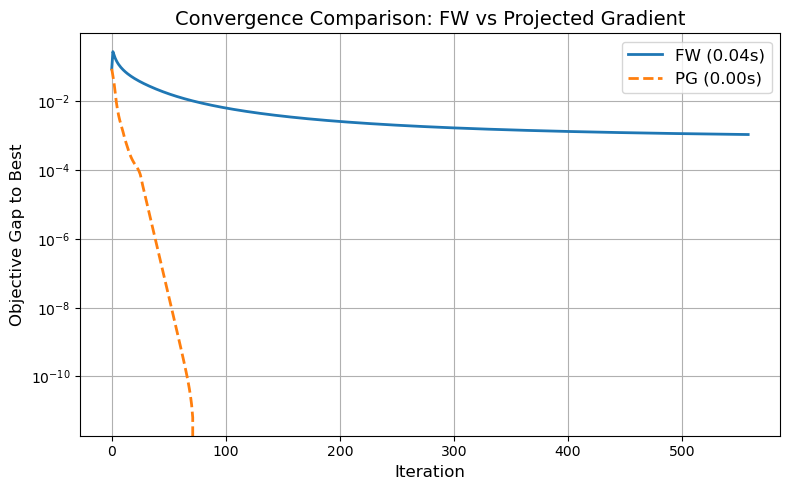

In [38]:
num_iters = 2000
line_search = 'fixed'

# Frank-Wolfe
start_fw = time.time()
x_fw, hist_fw = frank_wolfe(obj_func=obj_l2, grad_obj_func=grad_l2, A=A,
                             num_iters=num_iters, line_search='log', verbose=True)
time_fw = time.time() - start_fw
clique_fw, size_clique_fw = extract_clique_from_solution(x_fw, A)
n = A.shape[0]

# Projected Gradient
start_pg = time.time()
x_pg, hist_pg = projected_gradient(obj_func=obj_l2, grad_obj_func=grad_l2, proj=proj_simplex,
                                   A=A, num_iters=num_iters, line_search=line_search, verbose=True)
time_pg = time.time() - start_pg
clique_pg, size_clique_pg = extract_clique_from_solution(x_pg, A)

print("Algorithm Comparison Results".center(60, "="))
print(f"{'Algorithm':<20}{'Max Clique Size':<20}{'Time (s)':<10}{'Time/O(n)':<10}")
print(f"{'-'*60}")
print(f"{'Frank-Wolfe':<20}{size_clique_fw:<20}{time_fw:<10.4f}{time_fw/n:<10.5f}")
print(f"{'Projected Gradient':<20}{size_clique_pg:<20}{time_pg:<10.4f}{time_pg/n:<10.5f}")
print("="*60)

# Plot convergence (objective difference from best)
best_obj = max(max(hist_fw), max(hist_pg))
plt.figure(figsize=(8,5))
plt.plot([best_obj - f for f in hist_fw], label=f'FW ({time_fw:.2f}s)', linewidth=2)
plt.plot([best_obj - f for f in hist_pg], '--', label=f'PG ({time_pg:.2f}s)', linewidth=2)
plt.yscale('log')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Objective Gap to Best', fontsize=12)
plt.title('Convergence Comparison: FW vs Projected Gradient', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
